### 서울 지하철 시간대별 혼잡도 분석

#### 서울시 열린데이터 광장

- https://data.seoul.go.kr/index.do
    - 필요 데이터 다운로드

##### 필요 라이브러리 추가

In [1]:
## 경고 메시지 무시하기
import warnings

warnings.filterwarnings('ignore')

In [27]:
import pandas as pd
import numpy as np
import re                   ## 정규식 쓸 줄 압니까?
import missingno as msno
import matplotlib as plt
import seaborn as sns
import folium

In [28]:
## 한글 깨짐현상
import matplotlib
from matplotlib import font_manager, rc

font_path = 'C:/Windows/Fonts/NanumGothic.ttf' 
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font) # 한글깨짐현상 해결
matplotlib.rcParams['axes.unicode_minus'] = False  # 한글 사용시 마이너스 깨짐현상 해결

##### 분석 주제

- 서울의 카테고리별 관광지 정보를 통해 지도에 마커 표시
- 마커의 수가 많을 수록 관광이 유리할 것으로 예측
- 원본의 인코딩이 cp949 인데 전부 바꿀려니 버거움(그냥 쓴 후 mids 폴더에 저장할 때 utf-8로 변환저장할 것)

In [14]:
## 쇼핑관련 데이터 로드
df_shopping = pd.read_csv('./datas/seoul_tour_shopping.csv', encoding='cp949')
df_shopping.tail()

,키,분류1,분류2,분류3,검색어,명칭,행정 시,행정 구,행정 동
142,BE_IW17-0097,쇼핑/여가/가정,백화점,백화점 일반,경방/타임스퀘어,경방타임스퀘어,서울특별시,영등포구,영등포동
143,BE_IW17-0098,쇼핑/여가/가정,백화점,백화점 일반,동방백화점,동방백화점,서울특별시,동대문구,제기동
144,BE_IW17-0099,쇼핑/여가/가정,백화점,백화점 일반,선플라자백화점,선플라자백화점,서울특별시,영등포구,대림1동
145,BE_IW17-0100,쇼핑/여가/가정,백화점,백화점 일반,세운백화점,세운백화점,서울특별시,종로구,종로1.2.3.4가동
146,BE_IW17-0101,쇼핑/여가/가정,백화점,백화점 일반,여의도백화점,여의도백화점,서울특별시,영등포구,여의도동


In [15]:
## 필요한 경우 utf-8로 다시 저장하면 됨
df_shopping.to_csv('./mids/seoul_tour_shopping.csv', encoding='utf-8', index=False)

In [16]:
## 문화관련 데이터 로드
df_culture = pd.read_csv('./datas/seoul_tour_culture.csv', encoding='cp949')
df_culture.tail()

,메인 키,분류1,분류2,분류3,분류4,검색어,명칭,지번 주소,도로명 주소,행정 시,행정 구,행정 동
235,BE_LiST36-0080,교육/예술/종교,문화시설,미술관,NaN,예화랑,예화랑,NaN,NaN,서울특별시,강남구,신사동
236,BE_LiST36-0081,교육/예술/종교,문화시설,미술관,NaN,유아트/스페이스,유아트스페이스,NaN,NaN,서울특별시,강남구,청담동
237,BE_LiST36-0082,교육/예술/종교,문화시설,미술관,NaN,이목화랑,이목화랑,NaN,NaN,서울특별시,종로구,가회동
238,BE_LiST36-0083,교육/예술/종교,문화시설,미술관,NaN,이즈갤러리,이즈갤러리,NaN,NaN,서울특별시,종로구,종로1.2.3.4가동
239,BE_LiST36-0084,교육/예술/종교,문화시설,미술관,NaN,인사미술공간,인사미술공간,NaN,NaN,서울특별시,종로구,가회동


In [18]:
## 음식점관련 데이터 로드
df_food = pd.read_csv('./datas/seoul_tour_food.csv', encoding='cp949')
df_food.tail()

,키,분류1,분류2,분류3,검색어,명칭,행정 시,행정 구,행정 동
1099,BE_IW16-0070,한식/중식/일식,전통음식,한식 일반,고기시장,고기시장,서울특별시,양천구,신월5동
1100,BE_IW16-0071,한식/중식/일식,전통음식,한식 일반,고덕가든,고덕가든,서울특별시,강동구,고덕1동
1101,BE_IW16-0072,한식/중식/일식,전통음식,한식 일반,고래불,고래불,서울특별시,강남구,역삼1동
1102,BE_IW16-0073,한식/중식/일식,전통음식,한식 일반,고메홈,고메홈,서울특별시,강남구,대치4동
1103,BE_IW16-0074,한식/중식/일식,전통음식,한식 일반,고모네원조콩탕,고모네원조콩탕,서울특별시,강동구,성내3동


In [20]:
df_park = pd.read_csv('./datas/seoul_tour_zoo.csv', encoding='cp949')
df_park.tail()

,키,분류1,분류2,분류3,검색어,명칭,행정 시,행정 구,행정 동
16,BE_IW08-0017,관광/숙박,테마-보호구역,식물원,푸른수목원,푸른수목원,서울특별시,구로구,오류2동
17,BE_IW08-0018,관광/숙박,테마-보호구역,식물원,한라식물원,한라식물원,서울특별시,강동구,둔촌2동
18,BE_IW08-0019,관광/숙박,테마-보호구역,식물원,한백식물원,한백식물원,서울특별시,서초구,내곡동
19,BE_IW08-0020,관광/숙박,테마-보호구역,휴양림,산림청과학원/홍릉수목원,산림청과학원홍릉수목원,서울특별시,동대문구,청량리동
20,BE_IW08-0021,관광/숙박,테마-보호구역,휴양림,승화수목원,승화수목원,서울특별시,서초구,내곡동


In [33]:
## 필요없지만 테스트로 읽어봄
df_dramaset = pd.read_csv('./datas/seoul_tour_drama.csv', encoding='cp949')
df_dramaset.tail()

,키,분류1,분류2,분류3,검색어,명칭,행정 시,행정 구,행정 동
281,BE_IW04-0243,관광/숙박,테마-보호구역,영화/드라마/CF 촬영소,친구촬영지,친구촬영지,NaN,NaN,NaN
282,BE_IW04-0244,관광/숙박,테마-보호구역,영화/드라마/CF 촬영소,쾌걸춘향/촬영지,쾌걸춘향촬영지,전라북도,남원시,노암동
283,BE_IW04-0245,관광/숙박,테마-보호구역,영화/드라마/CF 촬영소,클래식촬영지,클래식촬영지,경기도,수원시 팔달구,행궁동
284,BE_IW04-0246,관광/숙박,테마-보호구역,영화/드라마/CF 촬영소,클래식촬영지,클래식촬영지,NaN,NaN,NaN
285,BE_IW04-0247,관광/숙박,테마-보호구역,영화/드라마/CF 촬영소,태극기휘날리며/촬영지,태극기휘날리며촬영지,경상남도,합천군,가회면


In [22]:
df_museum = pd.read_csv('./datas/seoul_tour_museum.csv', encoding='cp949')
df_museum.tail()

,키값,분류1,분류2,분류3,분류4,검색어,명칭,주소,도로명주소,행정시,행정구,행정동
37,BE_LiST38-0038,교육/예술/종교,문화시설,박물관,NaN,한국은행화폐/금융박물관,한국은행화폐금융박물관,NaN,NaN,서울특별시,중구,소공동
38,BE_LiST38-0039,교육/예술/종교,문화시설,박물관,NaN,한성백제박물관,한성백제박물관,NaN,NaN,서울특별시,송파구,오륜동
39,BE_LiST38-0040,교육/예술/종교,문화시설,박물관,NaN,허준박물관,허준박물관,NaN,NaN,서울특별시,강서구,가양2동
40,BE_LiST38-0041,교육/예술/종교,문화시설,박물관,NaN,호림박물관,호림박물관,NaN,NaN,서울특별시,관악구,미성동
41,BE_LiST38-0042,교육/예술/종교,문화시설,박물관,NaN,화정박물관,화정박물관,NaN,NaN,서울특별시,종로구,평창동


In [23]:
df_nature = pd.read_csv('./datas/seoul_tour_nature.csv', encoding='cp949')
df_nature.tail()

,키,명칭,대분류,주소,행정 시,행정 구,행정 동,대표전화,면적,지정일,교?안내
140,BE_IW14-0106,쌍문근린공원,산과공원,132 - 030 서울 도봉구 쌍문동 산80,서울특별시,도봉구,쌍문4동,02-2091-3754,NaN,NaN,NaN
141,BE_IW14-0107,아시아공원,산과공원,서울 송파구 잠실동 84번지,서울특별시,송파구,잠실7동,02-2147-3380,NaN,NaN,NaN
142,BE_IW14-0108,아차산,산과공원,구의2동 3,서울특별시,광진구,구의2동,NaN,NaN,NaN,NaN
143,BE_IW14-0001,양재천,생태탐방,서울특별시 강남구 영동2교 ~ 탄천합류부,서울특별시,강남구,삼성2동,02-445-1416,491022㎡(3.5㎞),NaN,지하철 3호선 도곡역 삼성타워팰리스 방면으로 나와 영동 4교 진입로
144,BE_IW14-0002,중랑천하류 철새보호구역,생태탐방,중랑천 한강 합류부~중랑천 청계천 합류부(서울숲 서쪽),서울특별시,성동구,성수동,02-2115-7550~5 02-2290-6851,591407㎡(3.5㎞),2005년 02월 16일,국철 응봉역에서 도보로 3분 지하철 2호선 한양대역에서 도보로 2분


In [24]:
df_hotel = pd.read_csv('./datas/seoul_tour_hotel.csv', encoding='cp949')
df_hotel.tail()

,메인 키,분류1,분류2,분류3,분류4,검색어,명칭,지번 주소,도로명 주소,행정 시,행정 구,행정 동
154,BE_LiST37-0155,관광/숙박,숙박,호텔 기타,NaN,CF호텔,CF호텔,NaN,NaN,서울특별시,송파구,방이2동
155,BE_LiST37-0156,관광/숙박,숙박,호텔 기타,NaN,갤러리호텔,갤러리호텔,NaN,NaN,서울특별시,은평구,녹번동
156,BE_LiST37-0157,관광/숙박,숙박,호텔 기타,NaN,서울파트너스/하우스,서울파트너스하우스,NaN,NaN,서울특별시,용산구,한남동
157,BE_LiST37-0158,관광/숙박,숙박,호텔 기타,NaN,세림호텔,세림호텔,NaN,NaN,서울특별시,종로구,종로1.2.3.4가동
158,BE_LiST37-0159,관광/숙박,숙박,호텔 기타,NaN,젤리호텔,젤리호텔,NaN,NaN,서울특별시,강남구,역삼1동


In [25]:
df_legacy = pd.read_csv('./datas/seoul_tour_legacy.csv', encoding='cp949')
df_legacy.tail()

,키,분류1,분류2,분류3,명칭,주소,도로명주소,행정 시,행정 구,행정 동
152,BE_LiST40-0110,관광/숙박,관광,문화재/유적지/능-묘,종묘영녕전,NaN,NaN,서울특별시,종로구,종로1.2.3.4가동
153,BE_LiST40-0111,관광/숙박,관광,문화재/유적지/능-묘,종묘제정,NaN,NaN,서울특별시,종로구,종로1.2.3.4가동
154,BE_LiST40-0112,관광/숙박,관광,문화재/유적지/능-묘,주합루,NaN,NaN,서울특별시,종로구,종로1.2.3.4가동
155,BE_LiST40-0113,관광/숙박,관광,문화재/유적지/능-묘,중화문,NaN,NaN,서울특별시,중구,소공동
156,BE_LiST40-0114,관광/숙박,관광,문화재/유적지/능-묘,즉조당,NaN,NaN,서울특별시,중구,소공동


In [26]:
df_street = pd.read_csv('./datas/seoul_tour_street.csv', encoding='cp949')
df_street.tail()

,키,검색 키워드,alias,최종 표기명,지번 주소,법정 시,법정 구,법정 동,행정 시,행정 구,행정 동,중심 좌표 X,중심 좌표 Y
129,BE_IW01-0037,장수길,장수길,장수길,서울시 성북구 삼선동 일대,서울특별시,성북구,삼선동1가,서울특별시,성북구,삼선동,127.020781,37.597161
130,BE_IW01-0038,둘레길2구간,둘레길2구간,둘레길2구간,서울시 성북구 성북동 일대,서울특별시,성북구,성북동,서울특별시,성북구,성북동,126.992150,37.596921
131,BE_IW01-0039,둘레길/순례길구간,순례길구간,둘레길순례길구간,서울시 강북구 우이동 일대,서울특별시,강북구,우이동,서울특별시,강북구,우이동,126.983266,37.664471
132,BE_IW01-0040,고향의거리,고향의거리,고향의거리,서울시 양천구 신정6동 일대,서울특별시,양천구,신정동,서울특별시,양천구,신정6동,126.862987,37.516577
133,BE_IW01-0041,왕십리곱창골목,왕십리곱창골목,왕십리곱창골목,서울시 중구 황학동 일대,서울특별시,중구,황학동,서울특별시,중구,황학동,127.020434,37.568610


#### 필요컬럼 정리

In [29]:
df_shopping['구분코드'] = df_shopping['키']
df_shopping['대분류'] = df_shopping['분류1']
df_shopping['중분류'] = df_shopping['분류2']
df_shopping['소분류'] = df_shopping['분류3']
df_shopping['시'] = df_shopping['행정 시']
df_shopping['구'] = df_shopping['행정 구']
df_shopping['동'] = df_shopping['행정 동']
df_shopping_new = df_shopping[['구분코드', '대분류', '중분류', '소분류', '명칭','시', '구', '동']]
df_shopping_new.tail()

,구분코드,대분류,중분류,소분류,명칭,시,구,동
142,BE_IW17-0097,쇼핑/여가/가정,백화점,백화점 일반,경방타임스퀘어,서울특별시,영등포구,영등포동
143,BE_IW17-0098,쇼핑/여가/가정,백화점,백화점 일반,동방백화점,서울특별시,동대문구,제기동
144,BE_IW17-0099,쇼핑/여가/가정,백화점,백화점 일반,선플라자백화점,서울특별시,영등포구,대림1동
145,BE_IW17-0100,쇼핑/여가/가정,백화점,백화점 일반,세운백화점,서울특별시,종로구,종로1.2.3.4가동
146,BE_IW17-0101,쇼핑/여가/가정,백화점,백화점 일반,여의도백화점,서울특별시,영등포구,여의도동


In [30]:
df_culture[['구분코드', '대분류', '중분류', '소분류', '시', '구', '동']] = df_culture[['메인 키', '분류1', '분류2', '분류3', '행정 시', '행정 구','행정 동']]
df_culture_new = df_culture[['구분코드', '대분류', '중분류', '소분류', '명칭','시', '구', '동']]
df_culture_new.tail()

,구분코드,대분류,중분류,소분류,명칭,시,구,동
235,BE_LiST36-0080,교육/예술/종교,문화시설,미술관,예화랑,서울특별시,강남구,신사동
236,BE_LiST36-0081,교육/예술/종교,문화시설,미술관,유아트스페이스,서울특별시,강남구,청담동
237,BE_LiST36-0082,교육/예술/종교,문화시설,미술관,이목화랑,서울특별시,종로구,가회동
238,BE_LiST36-0083,교육/예술/종교,문화시설,미술관,이즈갤러리,서울특별시,종로구,종로1.2.3.4가동
239,BE_LiST36-0084,교육/예술/종교,문화시설,미술관,인사미술공간,서울특별시,종로구,가회동


In [31]:
df_food[['구분코드', '대분류', '중분류', '소분류', '시', '구', '동']] = df_food[['키', '분류1', '분류2', '분류3', '행정 시', '행정 구','행정 동']]
df_food_new = df_food[['구분코드', '대분류', '중분류', '소분류', '명칭','시', '구', '동']]
df_food_new.tail()

,구분코드,대분류,중분류,소분류,명칭,시,구,동
1099,BE_IW16-0070,한식/중식/일식,전통음식,한식 일반,고기시장,서울특별시,양천구,신월5동
1100,BE_IW16-0071,한식/중식/일식,전통음식,한식 일반,고덕가든,서울특별시,강동구,고덕1동
1101,BE_IW16-0072,한식/중식/일식,전통음식,한식 일반,고래불,서울특별시,강남구,역삼1동
1102,BE_IW16-0073,한식/중식/일식,전통음식,한식 일반,고메홈,서울특별시,강남구,대치4동
1103,BE_IW16-0074,한식/중식/일식,전통음식,한식 일반,고모네원조콩탕,서울특별시,강동구,성내3동


In [32]:
df_park[['구분코드', '대분류', '중분류', '소분류', '시', '구', '동']] = df_park[['키', '분류1', '분류2', '분류3', '행정 시', '행정 구','행정 동']]
df_park_new = df_park[['구분코드', '대분류', '중분류', '소분류', '명칭','시', '구', '동']]
df_park_new.tail()

,구분코드,대분류,중분류,소분류,명칭,시,구,동
16,BE_IW08-0017,관광/숙박,테마-보호구역,식물원,푸른수목원,서울특별시,구로구,오류2동
17,BE_IW08-0018,관광/숙박,테마-보호구역,식물원,한라식물원,서울특별시,강동구,둔촌2동
18,BE_IW08-0019,관광/숙박,테마-보호구역,식물원,한백식물원,서울특별시,서초구,내곡동
19,BE_IW08-0020,관광/숙박,테마-보호구역,휴양림,산림청과학원홍릉수목원,서울특별시,동대문구,청량리동
20,BE_IW08-0021,관광/숙박,테마-보호구역,휴양림,승화수목원,서울특별시,서초구,내곡동


In [34]:
df_museum[['구분코드', '대분류', '중분류', '소분류', '시', '구', '동']] = df_museum[['키값', '분류1', '분류2', '분류3', '행정시', '행정구','행정동']]
df_museum_new = df_museum[['구분코드', '대분류', '중분류', '소분류', '명칭','시', '구', '동']]
df_museum_new.tail()

,구분코드,대분류,중분류,소분류,명칭,시,구,동
37,BE_LiST38-0038,교육/예술/종교,문화시설,박물관,한국은행화폐금융박물관,서울특별시,중구,소공동
38,BE_LiST38-0039,교육/예술/종교,문화시설,박물관,한성백제박물관,서울특별시,송파구,오륜동
39,BE_LiST38-0040,교육/예술/종교,문화시설,박물관,허준박물관,서울특별시,강서구,가양2동
40,BE_LiST38-0041,교육/예술/종교,문화시설,박물관,호림박물관,서울특별시,관악구,미성동
41,BE_LiST38-0042,교육/예술/종교,문화시설,박물관,화정박물관,서울특별시,종로구,평창동


In [35]:
## 손볼게 많은 데이터프레임1
df_nature[['중분류', '소분류']] = '산과공원'
df_nature[['구분코드', '시', '구', '동']] = df_nature[['키', '행정 시', '행정 구','행정 동']]
df_nature_new = df_nature[['구분코드', '대분류', '중분류', '소분류', '명칭','시', '구', '동']]
df_nature_new.tail()

,구분코드,대분류,중분류,소분류,명칭,시,구,동
140,BE_IW14-0106,산과공원,산과공원,산과공원,쌍문근린공원,서울특별시,도봉구,쌍문4동
141,BE_IW14-0107,산과공원,산과공원,산과공원,아시아공원,서울특별시,송파구,잠실7동
142,BE_IW14-0108,산과공원,산과공원,산과공원,아차산,서울특별시,광진구,구의2동
143,BE_IW14-0001,생태탐방,산과공원,산과공원,양재천,서울특별시,강남구,삼성2동
144,BE_IW14-0002,생태탐방,산과공원,산과공원,중랑천하류 철새보호구역,서울특별시,성동구,성수동


In [36]:
df_hotel[['구분코드', '대분류', '중분류', '소분류', '시', '구', '동']] = df_hotel[['메인 키', '분류1', '분류2', '분류3', '행정 시', '행정 구','행정 동']]
df_hotel_new = df_hotel[['구분코드', '대분류', '중분류', '소분류', '명칭','시', '구', '동']]
df_hotel_new.tail()

,구분코드,대분류,중분류,소분류,명칭,시,구,동
154,BE_LiST37-0155,관광/숙박,숙박,호텔 기타,CF호텔,서울특별시,송파구,방이2동
155,BE_LiST37-0156,관광/숙박,숙박,호텔 기타,갤러리호텔,서울특별시,은평구,녹번동
156,BE_LiST37-0157,관광/숙박,숙박,호텔 기타,서울파트너스하우스,서울특별시,용산구,한남동
157,BE_LiST37-0158,관광/숙박,숙박,호텔 기타,세림호텔,서울특별시,종로구,종로1.2.3.4가동
158,BE_LiST37-0159,관광/숙박,숙박,호텔 기타,젤리호텔,서울특별시,강남구,역삼1동


In [37]:
df_legacy[['구분코드', '대분류', '중분류', '소분류', '시', '구', '동']] = df_legacy[['키', '분류1', '분류2', '분류3', '행정 시', '행정 구','행정 동']]
df_legacy_new = df_legacy[['구분코드', '대분류', '중분류', '소분류', '명칭','시', '구', '동']]
df_legacy_new.tail()

,구분코드,대분류,중분류,소분류,명칭,시,구,동
152,BE_LiST40-0110,관광/숙박,관광,문화재/유적지/능-묘,종묘영녕전,서울특별시,종로구,종로1.2.3.4가동
153,BE_LiST40-0111,관광/숙박,관광,문화재/유적지/능-묘,종묘제정,서울특별시,종로구,종로1.2.3.4가동
154,BE_LiST40-0112,관광/숙박,관광,문화재/유적지/능-묘,주합루,서울특별시,종로구,종로1.2.3.4가동
155,BE_LiST40-0113,관광/숙박,관광,문화재/유적지/능-묘,중화문,서울특별시,중구,소공동
156,BE_LiST40-0114,관광/숙박,관광,문화재/유적지/능-묘,즉조당,서울특별시,중구,소공동


In [38]:
df_street[['대분류', '중분류', '소분류']] = '거리'
df_street[['구분코드', '시', '구', '동', '명칭']] = df_street[['키', '행정 시', '행정 구','행정 동', '최종 표기명']]
df_street_new = df_street[['구분코드', '대분류', '중분류', '소분류', '명칭','시', '구', '동']]
df_street_new.tail()

,구분코드,대분류,중분류,소분류,명칭,시,구,동
129,BE_IW01-0037,거리,거리,거리,장수길,서울특별시,성북구,삼선동
130,BE_IW01-0038,거리,거리,거리,둘레길2구간,서울특별시,성북구,성북동
131,BE_IW01-0039,거리,거리,거리,둘레길순례길구간,서울특별시,강북구,우이동
132,BE_IW01-0040,거리,거리,거리,고향의거리,서울특별시,양천구,신정6동
133,BE_IW01-0041,거리,거리,거리,왕십리곱창골목,서울특별시,중구,황학동


##### 합치기

In [50]:
df_final = pd.concat([df_food_new, df_culture_new, df_hotel_new, df_legacy_new, 
                      df_museum_new, df_park_new, df_street_new, df_nature_new, df_shopping_new], axis=0, ignore_index=True)
df_final.to_csv('./results/new_final.csv')
df_final.columns.name = '인덱스'
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   구분코드    2149 non-null   object
 1   대분류     2149 non-null   object
 2   중분류     2149 non-null   object
 3   소분류     2149 non-null   object
 4   명칭      2149 non-null   object
 5   시       2149 non-null   object
 6   구       2149 non-null   object
 7   동       2149 non-null   object
dtypes: object(8)
memory usage: 134.4+ KB


In [51]:
df_final['위치'] = df_final['시'] + ' ' + df_final['구'] + ' ' + df_final['동']
df_final.tail()

인덱스,구분코드,대분류,중분류,소분류,명칭,시,구,동,위치
2144,BE_IW17-0097,쇼핑/여가/가정,백화점,백화점 일반,경방타임스퀘어,서울특별시,영등포구,영등포동,서울특별시 영등포구 영등포동
2145,BE_IW17-0098,쇼핑/여가/가정,백화점,백화점 일반,동방백화점,서울특별시,동대문구,제기동,서울특별시 동대문구 제기동
2146,BE_IW17-0099,쇼핑/여가/가정,백화점,백화점 일반,선플라자백화점,서울특별시,영등포구,대림1동,서울특별시 영등포구 대림1동
2147,BE_IW17-0100,쇼핑/여가/가정,백화점,백화점 일반,세운백화점,서울특별시,종로구,종로1.2.3.4가동,서울특별시 종로구 종로1.2.3.4가동
2148,BE_IW17-0101,쇼핑/여가/가정,백화점,백화점 일반,여의도백화점,서울특별시,영등포구,여의도동,서울특별시 영등포구 여의도동


##### 위치 마킹

- 위치명으로 위경도를 역추적하는 모듈 - geopy

In [41]:
!pip install geopy

  Obtaining dependency information for geopy from https://files.pythonhosted.org/packages/e1/58/9289c6a03116025cdb61461d99b2493daa4967a80b13755463d71a0affeb/geopy-2.4.0-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/40.3 kB ? eta -:--:--
     ---------------------------------------- 40.3/40.3 kB 1.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/125.4 kB ? eta -:--:--
   ---------------------------------------- 125.4/125.4 kB 7.7 MB/s eta 0:00:00


In [42]:
from geopy.geocoders import Nominatim

def geocoding(address):
    geolocoder = Nominatim(user_agent='South Korea', timeout=None)
    geo = geolocoder.geocode(address)
    return [geo.latitude, geo.longitude]

In [53]:
df_final['위도'] = 0.0
df_final['경도'] = 0.0

In [54]:
df_final.tail()

인덱스,구분코드,대분류,중분류,소분류,명칭,시,구,동,위치,위도,경도
2144,BE_IW17-0097,쇼핑/여가/가정,백화점,백화점 일반,경방타임스퀘어,서울특별시,영등포구,영등포동,서울특별시 영등포구 영등포동,0.0,0.0
2145,BE_IW17-0098,쇼핑/여가/가정,백화점,백화점 일반,동방백화점,서울특별시,동대문구,제기동,서울특별시 동대문구 제기동,0.0,0.0
2146,BE_IW17-0099,쇼핑/여가/가정,백화점,백화점 일반,선플라자백화점,서울특별시,영등포구,대림1동,서울특별시 영등포구 대림1동,0.0,0.0
2147,BE_IW17-0100,쇼핑/여가/가정,백화점,백화점 일반,세운백화점,서울특별시,종로구,종로1.2.3.4가동,서울특별시 종로구 종로1.2.3.4가동,0.0,0.0
2148,BE_IW17-0101,쇼핑/여가/가정,백화점,백화점 일반,여의도백화점,서울특별시,영등포구,여의도동,서울특별시 영등포구 여의도동,0.0,0.0


In [55]:
for i in range (0, len(df_final['위치'])-1):
    df_final['위도'][i] = geocoding(df_final['위치'][i])[0]
    df_final['경도'][i] = geocoding(df_final['위치'][i])[1]
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [56]:
df_final.tail()

인덱스,구분코드,대분류,중분류,소분류,명칭,시,구,동,위치,위도,경도
2144,BE_IW17-0097,쇼핑/여가/가정,백화점,백화점 일반,경방타임스퀘어,서울특별시,영등포구,영등포동,서울특별시 영등포구 영등포동,37.522279,126.907857
2145,BE_IW17-0098,쇼핑/여가/가정,백화점,백화점 일반,동방백화점,서울특별시,동대문구,제기동,서울특별시 동대문구 제기동,37.578378,127.034467
2146,BE_IW17-0099,쇼핑/여가/가정,백화점,백화점 일반,선플라자백화점,서울특별시,영등포구,대림1동,서울특별시 영등포구 대림1동,37.493861,126.904876
2147,BE_IW17-0100,쇼핑/여가/가정,백화점,백화점 일반,세운백화점,서울특별시,종로구,종로1.2.3.4가동,서울특별시 종로구 종로1.2.3.4가동,37.578067,126.993047
2148,BE_IW17-0101,쇼핑/여가/가정,백화점,백화점 일반,여의도백화점,서울특별시,영등포구,여의도동,서울특별시 영등포구 여의도동,0.000000,0.000000


In [57]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   구분코드    2149 non-null   object 
 1   대분류     2149 non-null   object 
 2   중분류     2149 non-null   object 
 3   소분류     2149 non-null   object 
 4   명칭      2149 non-null   object 
 5   시       2149 non-null   object 
 6   구       2149 non-null   object 
 7   동       2149 non-null   object 
 8   위치      2149 non-null   object 
 9   위도      2149 non-null   float64
 10  경도      2149 non-null   float64
dtypes: float64(2), object(9)
memory usage: 184.8+ KB


In [59]:
df_final.to_csv('./results/final_loc.csv', encoding='utf-8', index=False)

##### 위의 경로로 만든 위치로 지도에 그리기

In [76]:
tour_map = folium.Map(location=[df_final['위도'].mean(), df_final['경도'].mean()], zoom_start=11)

for i, data in df_final.iterrows():
    string = f'[{data["명칭"]}] {data["위치"]}'  ## '[{}] {}'.format(data['명칭'], data['위치'])
    cpopup = folium.Popup(string, max_width=300)
    folium.Marker(location=[data['위도'], data['경도']], popup=cpopup).add_to(tour_map)
    
tour_map
## 정확한 위치는 아님

In [63]:
tour_map.save('./results/seoul_tour.html')

##### 추가

- R의 ggplot2 패키지를 사용하는 것처럼 만드는 시각화 도구 plotnine

In [65]:
!pip install plotnine

  Obtaining dependency information for plotnine from https://files.pythonhosted.org/packages/eb/c1/fcc5985eee6511aa321e68c8f813d9fdbe1b506713a95d4f612a5f963270/plotnine-0.12.3-py3-none-any.whl.metadata
  Obtaining dependency information for mizani<0.10.0,>0.9.0 from https://files.pythonhosted.org/packages/e2/95/d4e33d3f5bc9fee5512637661208b6b595bda58e9b6a66fa867137761dd7/mizani-0.9.3-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/233.8 kB ? eta -:--:--
     ------------------------------------ - 225.3/233.8 kB 6.9 MB/s eta 0:00:01
     -------------------------------------- 233.8/233.8 kB 4.8 MB/s eta 0:00:00
     ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
     -- ------------------------------------- 0.6/9.2 MB 20.5 MB/s eta 0:00:01
     ----- ---------------------------------- 1.2/9.2 MB 15.5 MB/s eta 0:00:01
     -------- ------------------------------- 1.9/9.2 MB 14.9 MB/s eta 0:00:01
     ---------- ----------------------------- 

In [66]:
from plotnine import *

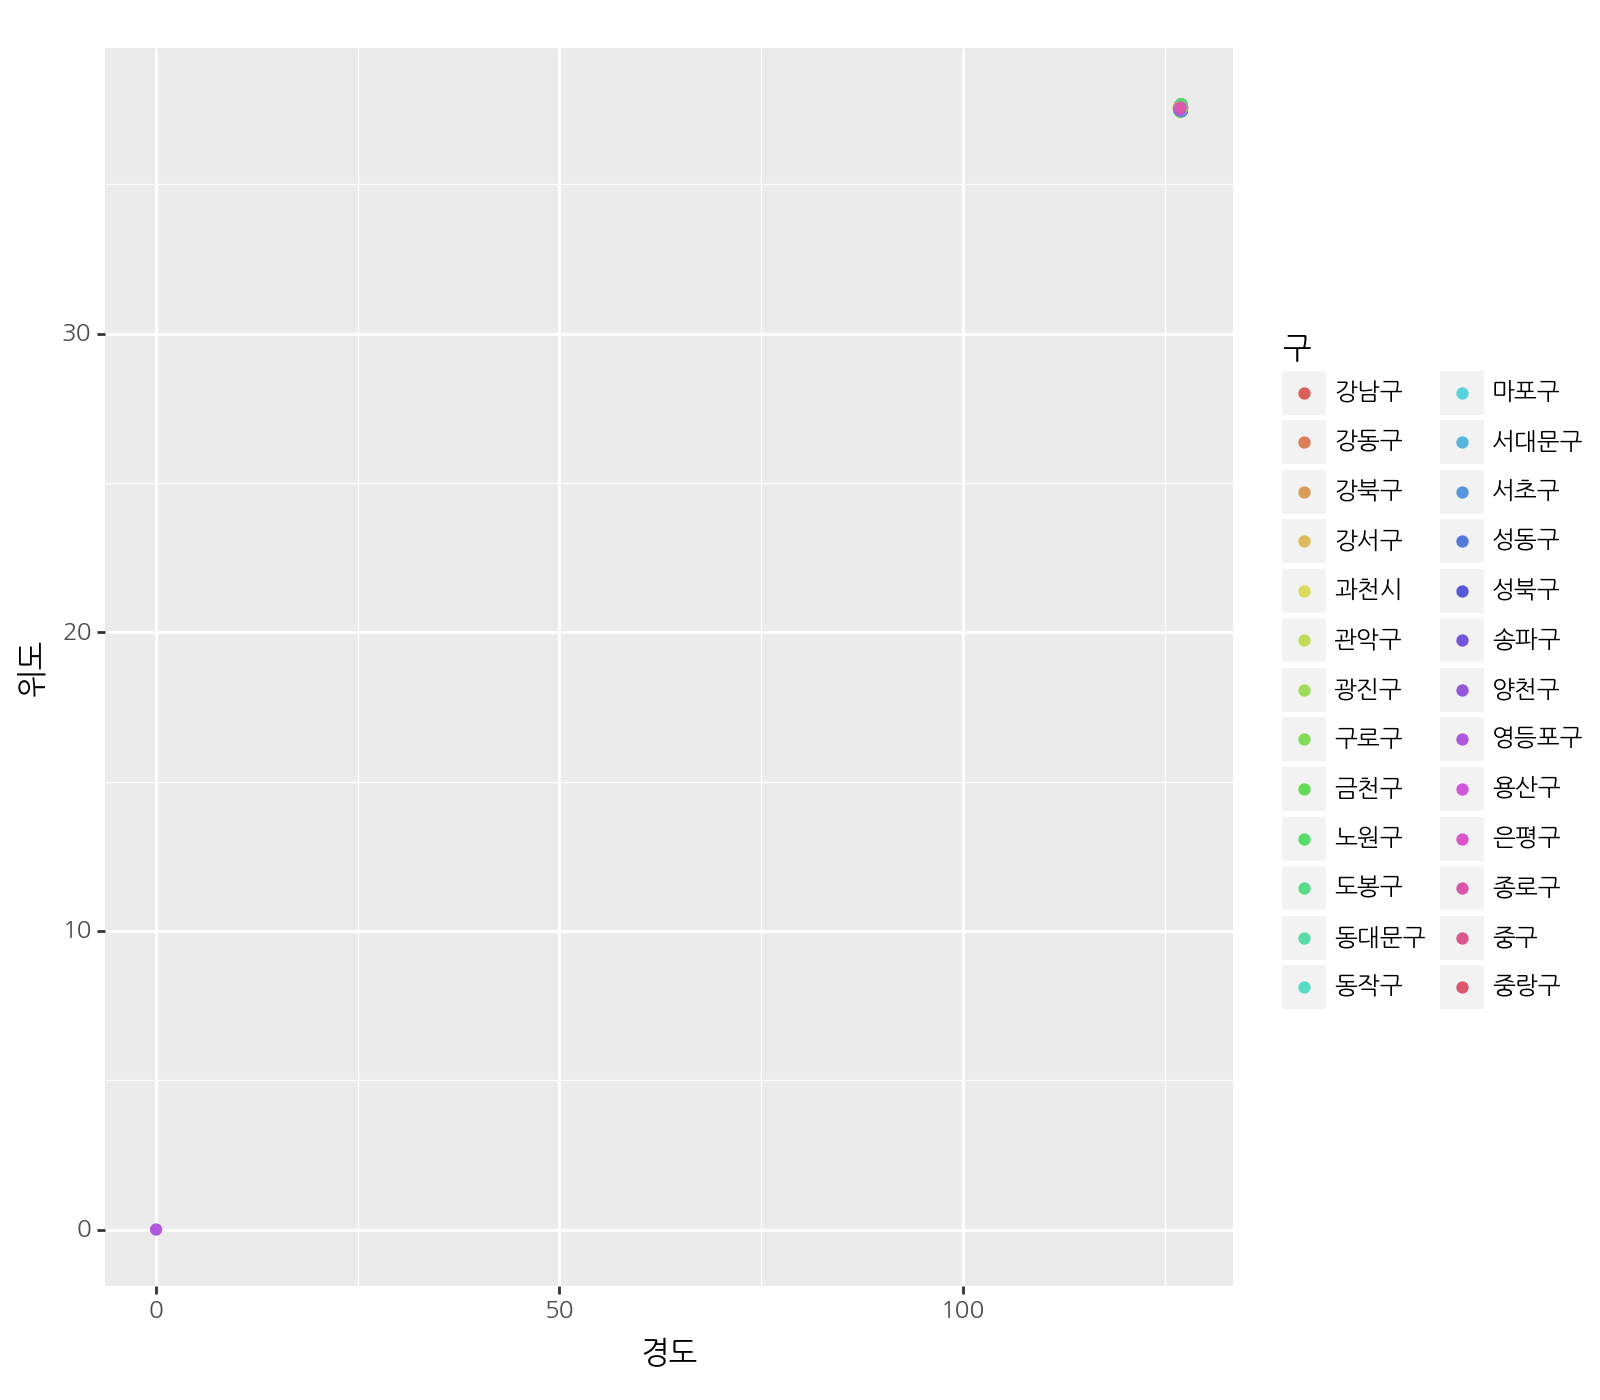

<Figure Size: (800 x 700)>

In [71]:
(
    ggplot(df_final, aes(x='경도', y='위도', color="구"))
        + geom_point()
        + theme(text=element_text(family='NanumGothic'), figure_size=(8, 7))
)

###### 데이터 하나가 이상함

0, 0 존재

In [73]:
df_final[df_final['위도'] < 37.0]

인덱스,구분코드,대분류,중분류,소분류,명칭,시,구,동,위치,위도,경도
2148,BE_IW17-0101,쇼핑/여가/가정,백화점,백화점 일반,여의도백화점,서울특별시,영등포구,여의도동,서울특별시 영등포구 여의도동,0.0,0.0


In [75]:
## 마지막 데이터 삭제
df_final.drop(index=2148, axis=0, inplace=True)

##### 위의 ggplot 다시

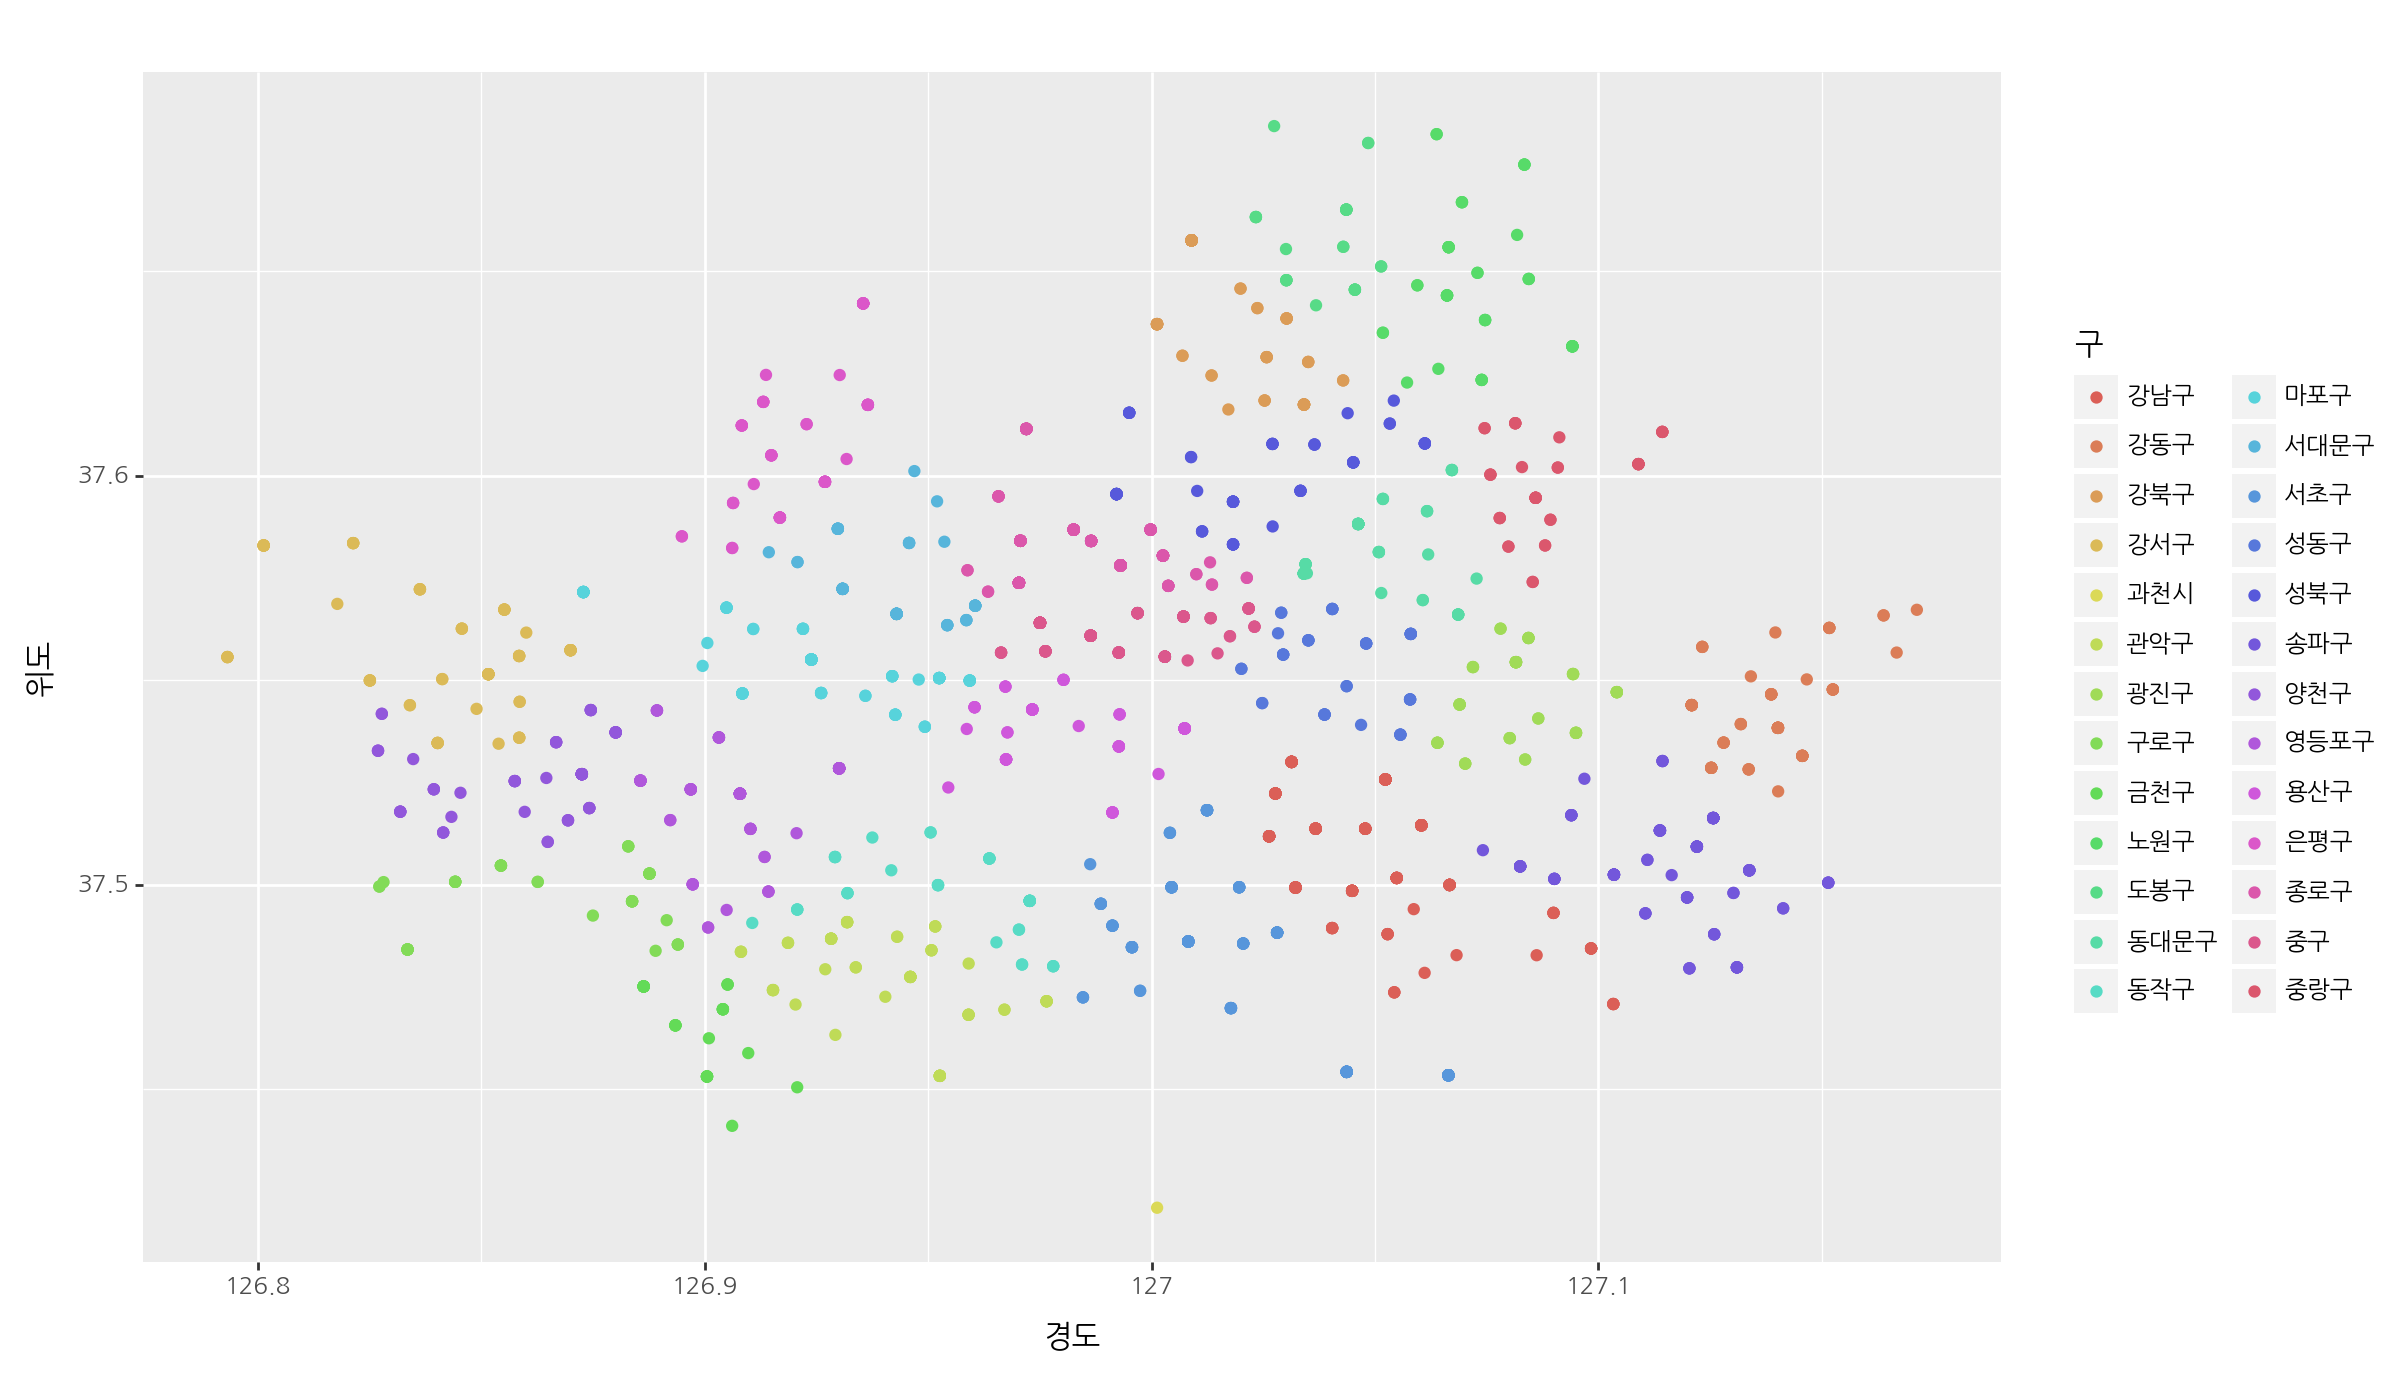

<Figure Size: (1200 x 700)>

In [78]:
(
    ggplot(df_final, aes(x='경도', y='위도', color="구"))
        + geom_point()
        + theme(text=element_text(family='NanumGothic'), figure_size=(12, 7))
)

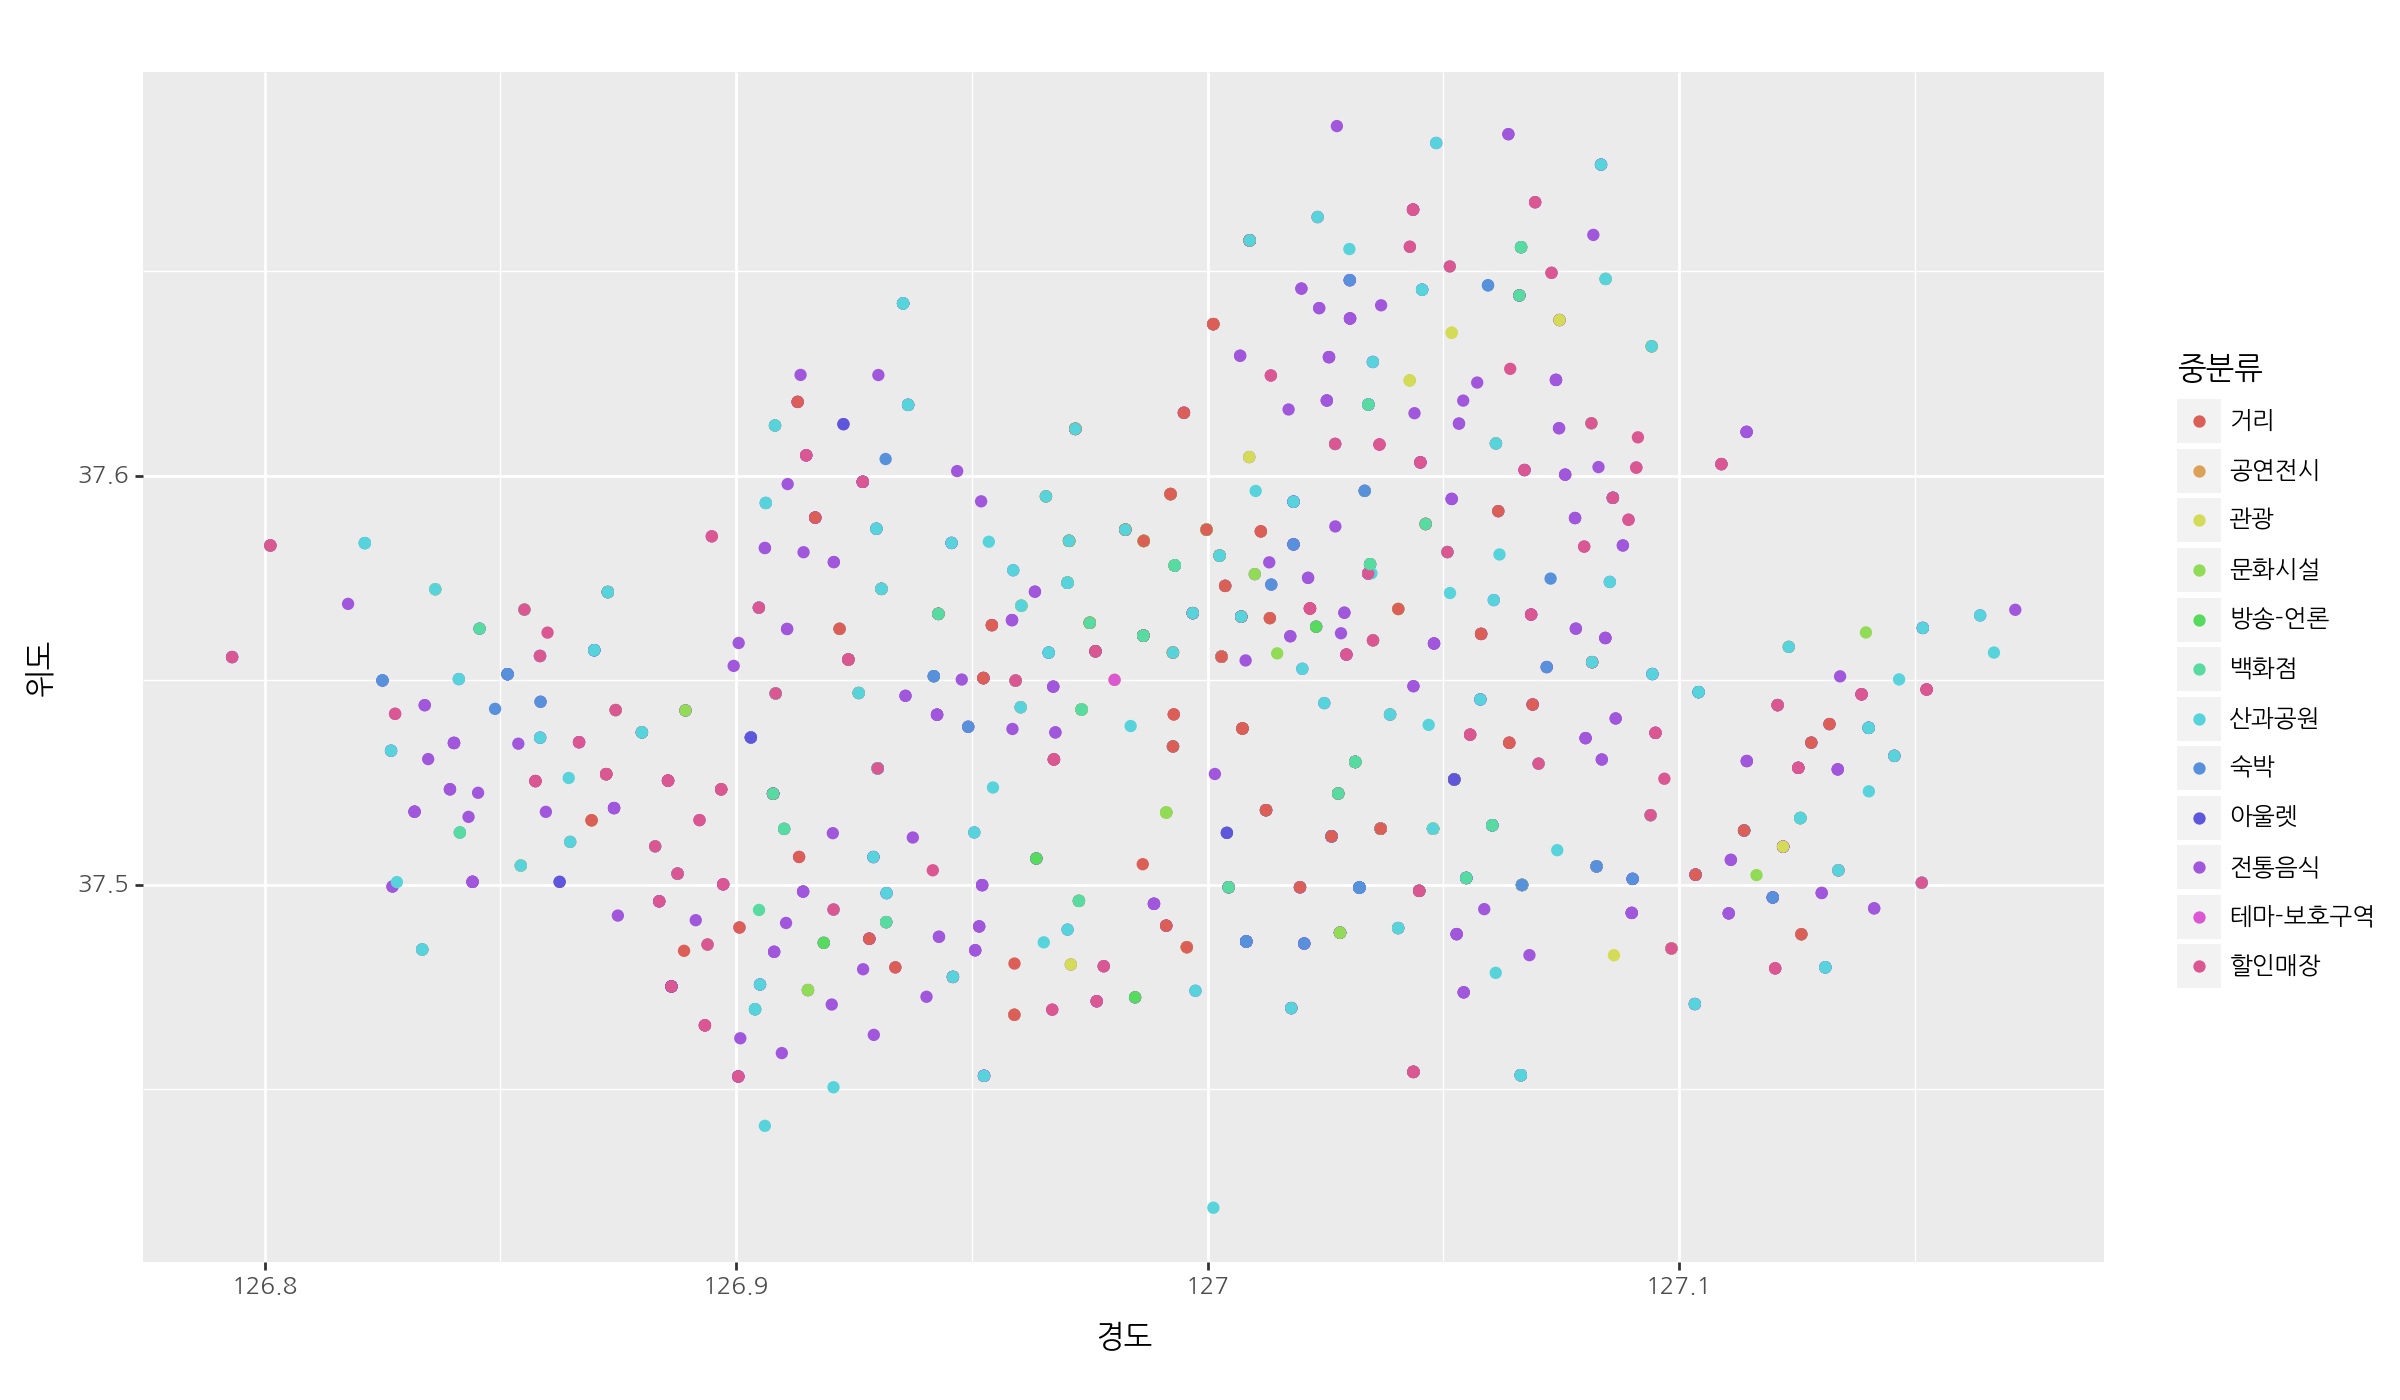

<Figure Size: (1200 x 700)>

In [79]:
## 중분류로 다시
(
    ggplot(df_final, aes(x='경도', y='위도', color="중분류"))
        + geom_point()
        + theme(text=element_text(family='NanumGothic'), figure_size=(12, 7))
)